# VAE Baby Steps

Some of this code was borrowed from the internet and it turns out I have questions about it.
I'd welcome comments/feedback.

In [1]:
# Setup
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Lambda
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Constants

In [2]:
img_dim = 64
img_channels = 3
original_dim = img_dim ** 2 * img_channels
intermediate_dim = 64
latent_dim = 2
# for the reparametrization trick.
# Q: what would the effect of tweaking this be?
epsilon_std = 1.0

## Encoder

In [3]:
x = Input(shape=(original_dim, ))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## Sampling

Why are we halving `z_log_var`?

In [4]:
def sampling(args):
    """Reparametrization trick"""
    z_mean, z_log_var = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


z = Lambda(sampling)([z_mean, z_log_var])

## Decoding

Why the *mean* in `x_decoded_mean`?

In [5]:
h_decoded = Dense(intermediate_dim, activation='relu')(z)
x_decoded_mean = Dense(original_dim, activation='sigmoid')(h_decoded)

## Loss Function

In [6]:
from keras.losses import mean_squared_error

In [7]:
def vae_loss(x, x_decoded):
    reconstruction_loss = mean_squared_error(x, x_decoded)
    tf.summary.scalar('reconstruction_loss', reconstruction_loss)
    kl_divergence_loss = -0.5 * K.mean(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    tf.summary.scalar('kl_loss', kl_divergence_loss)
    return reconstruction_loss + kl_divergence_loss

## The Model

In [8]:
vae = Model(x, x_decoded_mean)

In [11]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           786496      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            130         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            130         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [9]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

## Training

In [10]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [11]:
IMG_PATH = '/home/quickbeam/dlrc/training_data/Data/noisy_real_data/0.png'

In [46]:
def z_score_norm(images):
    return ((images.T - images.mean(axis=-1)) / images.std(axis=-1)).T

In [48]:
data = np.array([img_to_array(load_img(IMG_PATH)).flatten()])
data_normed = z_score_norm(data)

In [83]:
vae.fit(x=data_normed, y=data_normed, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 25ms/step - loss: 15.8348
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 15.5461
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 15.2447
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 14.9283
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 14.5959
Epoch 6/100
1/1 [==============================] - 0s 24ms/step - loss: 14.2467
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 13.8796
Epoch 8/100
1/1 [==============================] - 0s 26ms/step - loss: 13.4943
Epoch 9/100
1/1 [==============================] - 0s 25ms/step - loss: 13.0895
Epoch 10/100
1/1 [==============================] - 0s 26ms/step - loss: 12.6685
Epoch 11/100
1/1 [==============================] - 0s 23ms/step - loss: 12.2570
Epoch 12/100
1/1 [==============================] - 0s 30ms/step - loss: 11.8302
Epoch 13/100
1/1 [===================

## Playing with Model

In [84]:
encoder = Model(x, outputs=z_mean)

In [85]:
decoder_z = Input(shape=[latent_dim])
decoder_x = Dense(
    original_dim, activation='sigmoid')(
        Dense(intermediate_dim, activation='relu')(decoder_z))
decoder = Model(decoder_z, decoder_x)

In [86]:
encoder.predict(data_normed)

array([[ 3.23663163, -7.08713436]], dtype=float32)

In [87]:
dec = decoder.predict(encoder.predict(data_normed))

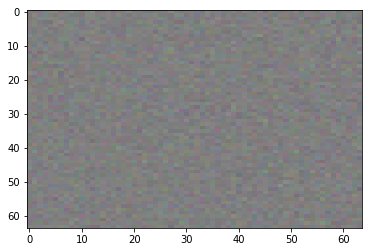

In [88]:
plt.imshow(dec.reshape((64, 64, 3)), interpolation='nearest', aspect='auto')

In [78]:
plt.imshow?